In [2]:
%%capture
!pip install -Uqq fastai duckduckgo_search gradio

## Import Libraries
   The main libraries needed are ***fastai*** for Model creation/training, and ***duckduckgo_search*** for Image Dataset creation.

In [3]:
from duckduckgo_search import DDGS
from fastdownload import download_url
from itertools import islice
from time import sleep 
import pickle
import model_deployment as md

from fastai.vision.all import *

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Dataset Creation
   We use DuckDuckGo's API to download images based on certain keywords, thereby creating an Image Dataset to train our model.

In [4]:
ddgs = DDGS()

def search_images(term, max_imgs=100):
    print(f'Searching for {term}')
    keywords = term
    ddgs_imgs = ddgs.images(keywords)
    limited_imgs = list(islice(ddgs_imgs, max_imgs))
    return L(limited_imgs).itemgot('image')

## Sample Images

  Here we download a sample image of each image class, Ants and Termites along with a random image.

Searching for ant images


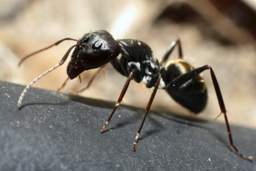

In [5]:
download_url(search_images('ant images', max_imgs=1)[0], 'ant.jpg', show_progress=True)
Image.open('ant.jpg').to_thumb(256,256)

Searching for termite images


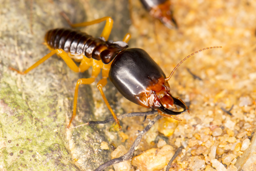

In [6]:
download_url(search_images('termite images', max_imgs=1)[0], 'termite.jpg', show_progress=True)
Image.open('termite.jpg').to_thumb(256,256)

Searching for bee images


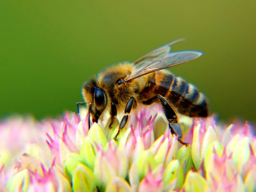

In [7]:
download_url(search_images('bee images', max_imgs=1)[0], 'bee.jpg', show_progress=True)
Image.open('bee.jpg').to_thumb(256,256)

## Dataset Images

   We create the Image Dataset by downloading images for both Ant and Termite classes.  

In [8]:
searches = 'ant', 'termite'
path = Path('AntHill')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} images'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} images in shade'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for ant images
Searching for ant images in shade


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Searching for termite images
Searching for termite images in shade


In [9]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

13

In [10]:
ant_len = len(os.listdir('/kaggle/working/AntHill/ant'))
termite_len = len(os.listdir('/kaggle/working/AntHill/termite'))
print(f'Total Images in Dataset: \n 1. Ant - {ant_len} images \n 2. Termite - {termite_len} images \n Total Images: {ant_len+termite_len}')

Total Images in Dataset: 
 1. Ant - 185 images 
 2. Termite - 182 images 
 Total Images: 367


## Data Augmentation  

- Create a DataLoader from Dataset images and apply Image Augmentations such as:  
    - Image Resizing
    - Random Flipping
    - Image Rotation
    - Affine Transformations

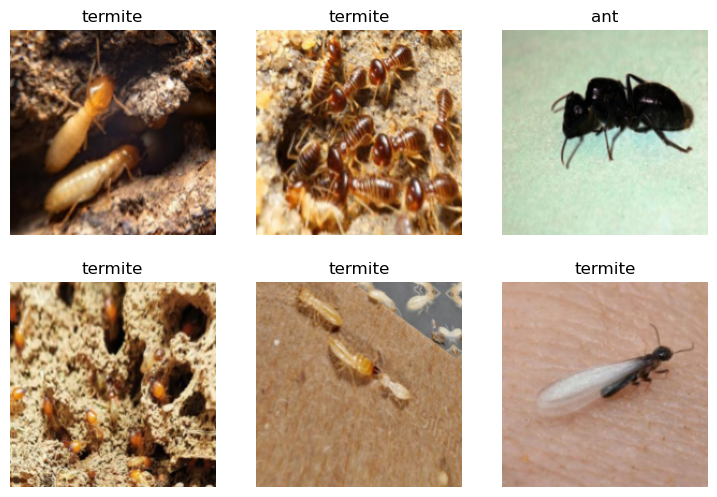

In [11]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')],
    batch_tfms=aug_transforms()
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

## Model Training
   Train a ***ResNet18*** model with the following considerations:
   - **Metric** : error_rate
   - **Epochs** : 8
   - **Base_LR** : 1e-3
   - **Callbacks** : SaveModelCallback(), ReduceLROnPlateau()

In [12]:
model = vision_learner(dls, 'resnet18', metrics=error_rate)

SuggestedLRs(valley=0.0030199517495930195, steep=7.585775847473997e-07)

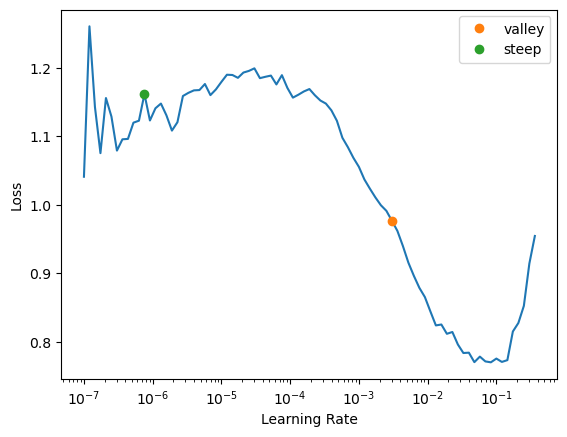

In [13]:
model.lr_find(suggest_funcs=(valley, steep))

In [14]:
model.fine_tune(8, base_lr=1e-3,cbs=[SaveModelCallback(fname='model'),ReduceLROnPlateau(patience=2)])

epoch,train_loss,valid_loss,error_rate,time
0,1.177688,0.520040,0.246575,00:03


Better model found at epoch 0 with valid_loss value: 0.5200397372245789.


epoch,train_loss,valid_loss,error_rate,time
0,0.632753,0.389502,0.191781,00:03
1,0.588071,0.255535,0.123288,00:02
2,0.519704,0.182017,0.054795,00:02
3,0.454485,0.179790,0.054795,00:02
4,0.403457,0.166213,0.095890,00:02
5,0.361521,0.163347,0.054795,00:02
6,0.336625,0.167840,0.082192,00:02
7,0.322230,0.168501,0.082192,00:02


Better model found at epoch 0 with valid_loss value: 0.38950201869010925.
Better model found at epoch 1 with valid_loss value: 0.2555348575115204.
Better model found at epoch 2 with valid_loss value: 0.1820167452096939.
Better model found at epoch 3 with valid_loss value: 0.17978951334953308.
Better model found at epoch 4 with valid_loss value: 0.16621267795562744.
Better model found at epoch 5 with valid_loss value: 0.1633474975824356.
Epoch 7: reducing lr to 4.9051540677034004e-08


## Confusion Matrix
   Plot a Confusion Matrix to assess quality of trained model.

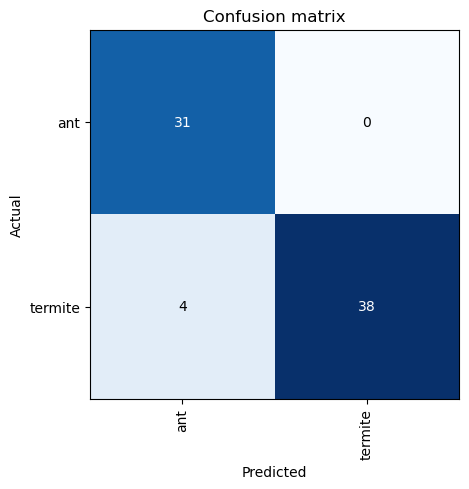

In [15]:
interp = ClassificationInterpretation.from_learner(model)
interp.plot_confusion_matrix()

## Export Model
   We save the model as a ***pickle*** file.

In [16]:
pickle.dump(model,open('model.pkl','wb'))

## Model Deployment
   We deploy the model using Gradio.

In [17]:
model = pickle.load(open('model.pkl','rb'))

In [18]:
categories = ('Ant','Termite')
examples = ['ant.jpg', 'termite.jpg', 'bee.jpg']

intf = md.Interface(model,categories,examples)
intf.create_interface()

/kaggle/usr/lib/model_deployment/model_deployment.py:32: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  image = gr.inputs.Image(shape=(256,256))
/kaggle/usr/lib/model_deployment/model_deployment.py:32: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  image = gr.inputs.Image(shape=(256,256))
/kaggle/usr/lib/model_deployment/model_deployment.py:33: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  label = gr.outputs.Label()
/kaggle/usr/lib/model_deployment/model_deployment.py:33: GradioUnusedKwargWarning: You have unused kwarg parameters in Label, please remove them: {'type': 'auto'}
  label = gr.outputs.Label()


Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://093b1143f889416cf6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
